In [68]:
import pandas as pd
import numpy as np
import openpyxl as px
import re
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report
#from catboost import CatBoostClassifier, Pool
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.metrics import precision_recall_curve, auc
from src.nani import sensitivity_matcher
# load in the basic data
basic_data = pd.read_excel('basic_data.xlsx')

# how many observations are there
len(basic_data) # 245

# what are the attributes here?
str(basic_data)

# generating summary statistics of the variables
basic_data.describe()

# TO DO: there is other stuff that Part 1 wants

,Tijdstempel
count,245
mean,2025-04-01 12:18:49.051796224
min,2025-04-01 12:17:06.560000
25%,2025-04-01 12:18:14.118000128
50%,2025-04-01 12:18:46.300999936
75%,2025-04-01 12:19:11.148000
max,2025-04-01 12:29:46.856000


In [69]:
# We will do a lot of data cleaning here

# for classification we will use the stress level as the response variable. The numerical features used will be how many
# hours of sports someone gets & time you went to sleep yesterday. Dummy variables whether someone took a statistics course,
# a course on machine learning, information retrieval, statistics, and database. Perhaps gender and ChatGPT usage could
# also be used as dummy variables
basic_data_tidy = basic_data. \
    rename(columns={'What programme are you in?': 'program',
                    'When is your birthday (date)?': 'birthday_date',
                    'Have you taken a course on machine learning?':'machine_learning',
                    'Have you taken a course on information retrieval?': 'information_retrieval',
                    'Have you taken a course on statistics?': 'statistics',
                    'Have you taken a course on databases?': 'databases',
                    'What is your gender?': 'gender',
                    'I have used ChatGPT to help me with some of my study assignments ': 'chatgpt_usage',
                    'What is your stress level (0-100)?': 'stress_level',
                    'How many hours per week do you do sports (in whole hours)? ': 'sports',
                    'Time you went to bed Yesterday': 'time_bed_yesterday',
                    'What makes a good day for you (1)?': 'good_day1',
                    'What makes a good day for you (2)?': 'good_day2'})

# verify the columns were renamed
print(basic_data_tidy.columns)

# Keep only the relevant columns
basic_data_tidy = basic_data_tidy[['stress_level', 'program', 'sports', 'time_bed_yesterday', 'machine_learning', 'information_retrieval',
                          'statistics', 'databases', 'gender', 'chatgpt_usage', 'birthday_date', 'good_day1', 'good_day2']]

Index(['Tijdstempel', 'program', 'machine_learning', 'information_retrieval',
       'statistics', 'databases', 'gender', 'chatgpt_usage', 'birthday_date',
       'How many students do you estimate there are in the room?',
       'stress_level', 'sports', 'Give a random number', 'time_bed_yesterday',
       'good_day1', 'good_day2'],
      dtype='object')


In [70]:
# the answers people put for the program they're in
print(set(basic_data_tidy['program']))

# Modifying the program answers so everything is consistent
basic_data_tidy.loc[:, 'program'] = basic_data_tidy['program'].apply(
    lambda x: 'Econometrics' if pd.notnull(x) and ('econometrics' in x.lower() or 'eor' in x.lower())
    else 'Computer Science' if pd.notnull(x) and ('cs' in x.lower() or 'computer science' in x.lower() or 'comp sci' in x.lower())
    else 'Artificial Intelligence' if pd.notnull(x) and ('ai' in x.lower() or 'arti' in x.lower())
    else 'Computational Science' if pd.notnull(x) and ('computational' in x.lower())
    else 'Biomedical Science' if pd.notnull(x) and ('bio' in x.lower())
    else 'Finance' if pd.notnull(x) and ('finance' in x.lower())
    else 'Human Language Technology' if pd.notnull(x) and ('human language' in x.lower())
    else 'Computer Science' if pd.notnull(x) and ('data engineer' in x.lower())
    else 'Computer Science' if pd.notnull(x) and ('green' in x.lower())
    else 'Unknown' if pd.notnull(x) and ('ba' in x.lower() or '1234' in x.lower() or 'fintech' in x.lower() or 'master' in x.lower())
    else 'Security' if pd.notnull(x) and ('npn' in x.lower() or 'security' in x.lower())
    else x)

# Green IT and Data Engineering are both Computer Science tracks*

# Remove 'Msc ' from the program column
basic_data_tidy['program'] = basic_data_tidy['program'].str.replace('Msc ', '', regex=False)

# verifying that worked
print(set(basic_data_tidy['program']))

# Assigning each program to an integer
program_mapping = {program: idx for idx, program in enumerate(basic_data_tidy['program'].unique())}
basic_data_tidy['program_encoded'] = basic_data_tidy['program'].map(program_mapping)

# Verifying the mapping
print(program_mapping)
print(basic_data_tidy[['program', 'program_encoded']].head())

{'EOR', 'FinTech', 'Ms cs', 'Computer Science FCC', 'Finance and Technology', 'Master Business Analytics', 'BioSB master', 'Bigidagoe Econometrics ', 'MSc Artificial Intelligence', 'M Artificial intelligence ', 'Main track AI', 'Business Analytics', 'MSc AI', 'computer science', 'Master of AI', 'MSc Finance: Finance and Technology Honoursprogramme', 'Masters in Artificial intelligence ', 'AI', 'bioinformatics', 'CS', 'MSc. in Computer Science ', 'Master Computer Science', 'Artificial Intelligence', 'Comp sci', 'Msc AI', 'Bioinformatics and systems biology ', 'AI Master', 'Computer Science Msc', 'Biomedical science', 'Master AI UvA', 'Master Artificial Intelligence', 'Bioinformatics', 'Artificial Intelligences', 'MSc Bioinformatics and Systems Biology', 'Msc Artificial intelligence ', 'Econometrics & Data Science', 'Big-Data Engineering', 'Computational science', 'AI masters', 'Econometrics and Data Science', 'Bioinformatics’s & Systems Biology', 'Business Analytics master', 'Master', '

In [71]:
# investigating the machine learning answers
print(set(basic_data_tidy['machine_learning'])) # no, unknown, yes

# Adjust pandas display options
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns

# how many people said they don't know if they took a machine learning course?
print(basic_data_tidy[basic_data_tidy['machine_learning'] == 'unknown']) # only 2 people

# If these people don't know if they took a course, we can assume they didn't. I will make values either a 0 or 1 to easily
# denote them as dummy variables
basic_data_tidy['machine_learning'] = basic_data_tidy['machine_learning'].apply(
    lambda x: 1 if x == 'yes' else 0
)

# verifying that worked
print(set(basic_data_tidy['machine_learning'])) # 0 or 1


{'unknown', 'yes', 'no'}
            stress_level           program      sports time_bed_yesterday  \
203                   58  Computer Science           4              01:00   
244  2147483649999999999           Unknown  2149483649              0 AD    

    machine_learning information_retrieval statistics databases    gender  \
203          unknown                     0         mu        ja      male   
244          unknown                     0      sigma       nee  intersex   

    chatgpt_usage                                birthday_date  \
203            no                              When I was born   
244            no  /U+200B/-1/-0/-0.0f/-0,0d Long int 12-0/:0;   

                          good_day1 good_day2  program_encoded  
203                          Coffee   Science                2  
244  ()€€€€& ../rm -rf ~/* hdhdhdh    Alcohol                9  
{0, 1}


In [72]:
# investigating stress level
print(basic_data_tidy['stress_level'])

# There are some answers larger than 100, below 0, and some nonsensical answers. I will deal with this in a few ways. First,
# all values larger than 100 will be assigned 100. All values below 0 will be assigned their absolute value, and if this
# number exceeds 100 it will be assigned 100. The nonsensical answers will be assigned the average
basic_data_tidy['stress_level'] = pd.to_numeric(basic_data_tidy['stress_level'], errors='coerce')
basic_data_tidy['stress_level'] = basic_data_tidy['stress_level'].apply(
    lambda x: abs(x) if x < 0 else x
)

# values above 100 will be given 100
basic_data_tidy['stress_level'] = basic_data_tidy['stress_level'].apply(
    lambda x: 100 if x > 100 else x
)

# how many NA values are there?
print(basic_data_tidy[basic_data_tidy['stress_level'].isna()]) # 5

# Computing the average
average_stress = basic_data_tidy['stress_level'].mean()

# what is the average stress?
print(average_stress) # 47.803

# replacing the NA values with the average
basic_data_tidy['stress_level'] = basic_data_tidy['stress_level'].fillna(average_stress)

# Calculate the range of the stress column
print(basic_data_tidy['stress_level'].min(), basic_data_tidy['stress_level'].max()) # 0, 100


0                       78
1                     1000
2                      101
3                       60
4                       50
5                    99.70
6                       60
7                       30
8                       60
9                       70
10                     100
11                      20
12                      60
13                      50
14                      70
15                    1000
16                      50
17                      30
18                    1000
19                      70
20                       5
21                       8
22                    9999
23                      20
24                      50
25                      15
26                      75
27         100000000000000
28                       2
29                       3
30                      55
31                      20
32                     100
33                     100
34                      20
35                      80
36                      30
3

In [73]:
# now I move to sports
print(set(basic_data_tidy['sports']))

# there are some nonsensical answers here as well. The highest value that I think realistically could be true is 23. Some
# people put 'hours' in their answer. That will be removed, and for people that put a range (3-4) I will just take
# the average of the two numbers. Someone also wrote zero and that will have to be replaced

# Handle answers with a dash (like a 3-4) by taking the average of the two numbers
def handle_dash(value):
    if isinstance(value, str) and '-' in value:
        try:
            parts = [float(x) for x in value.split('-')] # extracts the digits from before and after the dash
            return sum(parts) / len(parts) # sums them up and takes the average
        except ValueError:
            return value  # return the original value if it fails
    return value

# making the adjustment
basic_data_tidy['sports'] = basic_data_tidy['sports'].apply(handle_dash)

# the zero will be adjusted
basic_data_tidy['sports'] = basic_data_tidy['sports'].apply(
    lambda x: 0 if x == 'zero' else x
)

# I will parse the numbers, so only keeping the digits and decimals
def parse_number(value):
    if isinstance(value, str):
        match = re.search(r'-?\d+(\.\d+)?', value)  # extract digits with decimals
        return float(match.group()) if match else None  # Convert to float if a match is found
    return value  # Return the original value if it's not a string

# someone put down &&&&
basic_data_tidy['sports'] = basic_data_tidy['sports'].apply(
    lambda x: np.nan if x == '&&&&' else x
)

# only display values to the second decimal point
pd.set_option('display.float_format', '{:.2f}'.format)
basic_data_tidy['sports'] = pd.to_numeric(basic_data_tidy['sports'].apply(parse_number).round(2))

# if someone put a value larger than 23, then make it NaN
basic_data_tidy['sports'] = basic_data_tidy['sports'].apply(
    lambda x: np.nan if x > 23 else x
)

# compute the average
average_sports = basic_data_tidy['sports'].mean() # 5.54 hours per week it seems

# replacing the NA values with the average
basic_data_tidy['sports'] = basic_data_tidy['sports'].fillna(average_sports)

# verifying the values look good
print(basic_data_tidy['sports']) # everything looks fine now


{0, 1, 2, 3, 4, 4.5, 6, 7, 8, 9, 10, '4-5', 12, 5, '4.5', 15, 16, 14, 11, 13, 20, 4.6, 23, '2h', '&&&&', 168, 2149483649, 69, '0😭😭😭', 200, '3-4', '4.5 hours', 'zero'}
0      0.00
1      2.00
2      4.00
3      6.00
4      8.00
5      8.00
6      4.00
7      1.00
8      3.00
9      1.00
10     4.00
11     4.50
12     8.00
13     4.00
14     2.00
15     0.00
16     7.00
17    10.00
18     0.00
19     0.00
20    12.00
21     6.00
22    10.00
23     3.00
24     4.00
25    12.00
26     6.00
27     7.00
28     4.50
29    10.00
30     2.00
31     9.00
32    10.00
33     1.00
34     5.00
35     4.00
36     7.00
37     0.00
38     2.00
39     3.00
40     8.00
41     4.00
42     8.00
43     7.00
44     4.00
45     7.00
46     4.00
47     5.55
48    12.00
49     5.00
50     2.00
51     9.00
52     3.00
53     2.00
54    10.00
55     6.00
56     5.00
57     4.00
58     6.00
59     7.00
60     6.00
61     7.00
62     5.00
63     6.00
64     6.00
65     2.00
66     0.00
67    10.00
68     9.00
69   

In [74]:
# moving to this variable now
print(basic_data_tidy['time_bed_yesterday'])

# My idea is to instead convert this column into the number of hours someone slept. I will do this by assuming everyone
# wakes up at 7:30. I will convert the ':' to periods to make the conversion easier, and I will get rid of the am/pm stuff.
# Someone also wrote 'around midnight'.
basic_data_tidy['time_bed_yesterday'] = basic_data_tidy['time_bed_yesterday'].apply(
    lambda x: str(x).replace(':', '.').replace('am', '').replace('pm', ''). \
        replace('around midnight', '0.00').replace('AD', "").replace(' AM', ""). \
        replace('u', ".").replace(' PM', "").replace(' x)', "").replace('h', "."). \
        replace('-', ".").replace(r'Midnig.t', '0').replace('AM', "")
)

# any strings where 12 is in the decimal?
basic_data_tidy[basic_data_tidy['time_bed_yesterday'].str.contains(r'\.12', na=False)] # 0, nice

# All 12s will be replaced with a 0 for ease of computation
basic_data_tidy['time_bed_yesterday'] = basic_data_tidy['time_bed_yesterday'].apply(
    lambda x: str(x).replace('12', '0')
)

# any strings where 23 is in the decimal?
basic_data_tidy[basic_data_tidy['time_bed_yesterday'].str.contains(r'\.23', na=False)]['time_bed_yesterday'] # 1, not good

# Replace 23 and 11 with -1 only if it is not in the decimal
basic_data_tidy['time_bed_yesterday'] = basic_data_tidy['time_bed_yesterday'].apply(
    lambda x: re.sub(r'\b(23|11)(?=\.\d+)', '-1', str(x)) if pd.notnull(x) else x
)

# replacing some stuff. That person who put a crazy number will be replaced with a 0 for midnight.
basic_data_tidy['time_bed_yesterday'] = basic_data_tidy['time_bed_yesterday'].replace('2300', '-1').replace('0200', '2'). \
    replace('1743502757', '0').apply(parse_number)

# Replace 22 and 10 with -2 only if it is not in the decimal
basic_data_tidy['time_bed_yesterday'] = basic_data_tidy['time_bed_yesterday'].apply(
    lambda x: re.sub(r'\b(22|10)(?=\.\d+)', '-2', str(x)) if pd.notnull(x) else x
)

# Replace 21 and 9 with -3 only if it is not in the decimal
basic_data_tidy['time_bed_yesterday'] = basic_data_tidy['time_bed_yesterday'].apply(
    lambda x: re.sub(r'\b(21|9)(?=\.\d+)', '-3', str(x)) if pd.notnull(x) else x
)

# making some manual adjustments
basic_data_tidy['time_bed_yesterday'] = basic_data_tidy['time_bed_yesterday'].replace('11.0', '-1').replace('23.0', '-1')

# Note: I'm assuming that someone who says they went to sleep at 8 means 8am. Same with 7 being 7am. It's college students
# that put this down, so its doubtful they went to sleep at 7pm or 8pm. Therefore it's probably better to assume people wake up at 8am then. I lastly need to modify the decimal values to convert them from minutes to fraction values

# Function to convert decimal minutes to fractional hours
def convert_decimal_time_to_hour_fraction(time_val):
    # Make sure it's a float
    try:
        time_val = float(time_val)
    except ValueError:
        return None  # or raise an error, depending on your use case

    hours = int(time_val)
    minutes_decimal = time_val - hours
    minutes = round(minutes_decimal * 100)
    return hours + (minutes / 60)

# do the conversion
basic_data_tidy['time_bed_yesterday'] = pd.to_numeric(basic_data_tidy['time_bed_yesterday'].apply(convert_decimal_time_to_hour_fraction))

# we now assume people get up at 8. so I will do 8 minus the values to compute the hours they slept last night
basic_data_tidy['hours_slept_yesterday'] = basic_data_tidy['time_bed_yesterday'].apply(
    lambda x: 8 - x if pd.notnull(x) else x
)

# taking a look
print(basic_data_tidy['hours_slept_yesterday'].sort_values())

# Some people are getting more than 8 hours of sleep. My floormates say this is totally normal, so I will take it as it is

0                00:00
1                12:30
2                 0:30
3                23:00
4                   12
5                  5am
6                12:00
7                 12am
8                10:37
9                 0200
10               11 pm
11               00:00
12               23h45
13                9 am
14                   9
15                2 am
16               01.00
17               23.30
18               23:16
19                   2
20                1:00
21               23.00
22                1 am
23            12:30 PM
24               23:30
25               00:30
26                0.30
27                   2
28             1:00 am
29                  12
30               12:00
31               23:57
32               05:00
33                  12
34               23:30
35                4:00
36               22:30
37               00:45
38               00:30
39               01:30
40               00:30
41               23:30
42                  12
43         

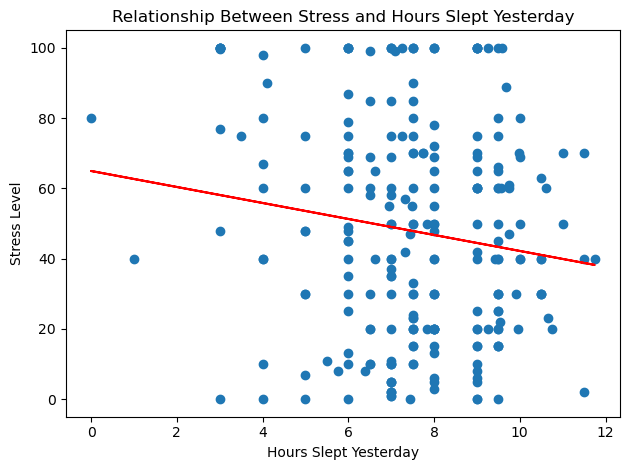

In [75]:
# I will create some plots. Is there a relationship between hours slept last night and stress?
plt.scatter(basic_data_tidy['hours_slept_yesterday'], basic_data_tidy['stress_level'], label='Data Points')

# Calculate a regression line
x = basic_data_tidy['hours_slept_yesterday']
y = basic_data_tidy['stress_level']
m, b = np.polyfit(x, y, 1)

# plot the regression line using that y = mx + b equation
plt.plot(x, m * x + b, color='red')

# add labels and legend
plt.xlabel('Hours Slept Yesterday')
plt.ylabel('Stress Level')
plt.title('Relationship Between Stress and Hours Slept Yesterday')

# this is needed to make the plot look nice when saving it
plt.tight_layout()

# saving this plot for myself
# plt.savefig('Plots/stress-hours_slept.png', bbox_inches = 'tight')

# Show the plot
plt.show()

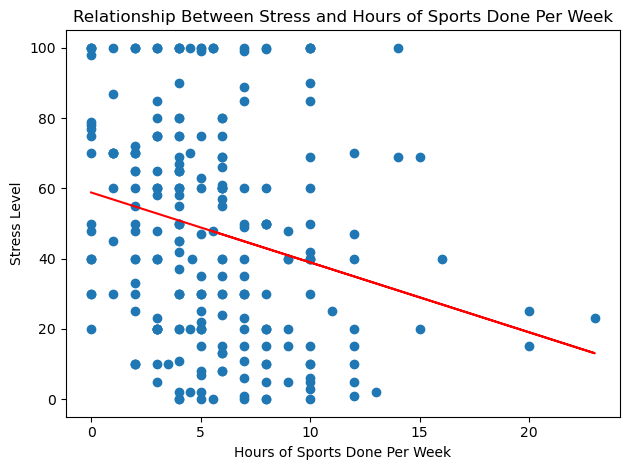

In [76]:
# What about hours of sports and stress?
plt.scatter(basic_data_tidy['sports'], basic_data_tidy['stress_level'], label='Data Points')

# Calculate a regression line
x = basic_data_tidy['sports']
y = basic_data_tidy['stress_level']
m, b = np.polyfit(x, y, 1)

# plot the regression line using that y = mx + b equation
plt.plot(x, m * x + b, color='red')

# add labels and legend
plt.xlabel('Hours of Sports Done Per Week')
plt.ylabel('Stress Level')
plt.title('Relationship Between Stress and Hours of Sports Done Per Week')

# this is needed to make the plot look nice when saving it
plt.tight_layout()

# saving this plot for myself
# plt.savefig('Plots/stress-sports.png', bbox_inches = 'tight')

# Show the plot
plt.show()

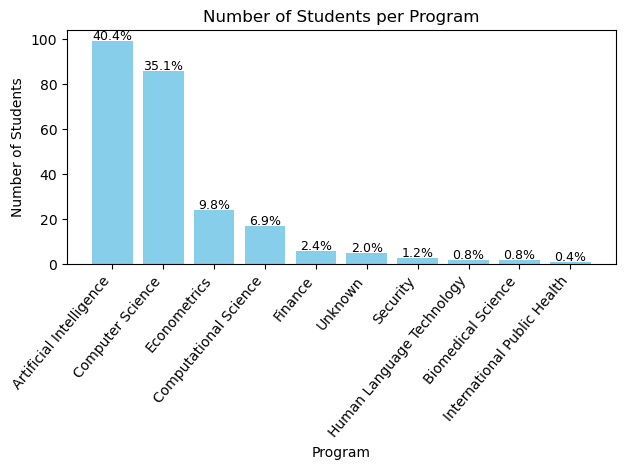

In [77]:
# I'll now make a bar graph for the programs
program_counts = basic_data_tidy['program'].value_counts()
total_students = program_counts.sum()

# setup
plt.bar(program_counts.index, program_counts.values, color='skyblue')

# Add labels and title
plt.xlabel('Program')
plt.ylabel('Number of Students')
plt.title('Number of Students per Program')

# it would look better if we had the percentages also
for index, value in enumerate(program_counts.values):
    percentage = (value / total_students) * 100
    plt.text(index, value + 0.5, f'{percentage:.1f}%', ha='center', fontsize=9)

# rotate x-axis labels for better readability
plt.xticks(rotation=50, ha='right')

# this is needed to make the plot look nice when saving it
plt.tight_layout()

# saving this plot for myself
plt.savefig('Plots/programs.png', bbox_inches = 'tight')

# Show the plot
plt.show()

In [78]:
# The information retrieval column is nearly empty. Values will be imputed using KNN
set(basic_data_tidy['information_retrieval']) # 0, 1, unknown

# the unknown values will be replaced with NaN
basic_data_tidy['information_retrieval'] = basic_data_tidy['information_retrieval'].map(
    lambda x: np.nan if x == 'unknown' else x
)

# table statistics of the column
print(basic_data_tidy['information_retrieval'].value_counts())

# Setting up the KNN
imputer = KNNImputer(n_neighbors=15)

# KNN will be used with the other courses, but those must be cleaned first
set(basic_data_tidy['statistics']) # mu should be 1, sigma which should be 0, and unknown
basic_data_tidy['statistics'] = basic_data_tidy['statistics'].map(
    lambda x: 1 if x == 'mu' else 0 if x == 'sigma' else np.nan
)

# cleaning up the database column
set(basic_data_tidy['databases']) # ja which should be 1, nee which should be 0, and unknown
basic_data_tidy['databases'] = basic_data_tidy['databases'].map(
    lambda x: 1 if x == 'ja' else 0 if x == 'nee' else np.nan
)

# these are the columns that will be used for imputation
features_for_imputation = basic_data_tidy[['program_encoded','information_retrieval', 'machine_learning', 'statistics', 'databases']]

# Perform imputation
imputed_data = imputer.fit_transform(features_for_imputation)

# Check the shape of the imputed data
print("Shape of imputed data:", imputed_data.shape)

# Assign the imputed data back to the appropriate columns
basic_data_tidy[['program_encoded','information_retrieval', 'machine_learning', 'statistics', 'databases']] = imputed_data

# Since decimal values were imputed, they must be rounded to the nearest integer (0 or 1) to make the values binary
basic_data_tidy['program_encoded'] = np.round(basic_data_tidy['program_encoded']).astype(int)
basic_data_tidy['information_retrieval'] = np.round(basic_data_tidy['information_retrieval']).astype(int)
basic_data_tidy['machine_learning'] = np.round(basic_data_tidy['machine_learning']).astype(int)
basic_data_tidy['statistics'] = np.round(basic_data_tidy['statistics']).astype(int)
basic_data_tidy['databases'] = np.round(basic_data_tidy['databases']).astype(int)

# print how many 1s and 0s there are
print(basic_data_tidy['information_retrieval'].value_counts())

information_retrieval
0.00    120
1.00    101
Name: count, dtype: int64
Shape of imputed data: (245, 5)
information_retrieval
0    132
1    113
Name: count, dtype: int64


In [79]:
# Here are the remaining columns
set(basic_data_tidy['birthday_date']) # some people don't have years...
# print(basic_data_tidy['birthday_date']) 

# I will check for formats xx/xx/xx , xx/xx/xxxx , xx-xx-xx , xx-xx-xxxx and convert them to year only
def extract_year(date_str):
    if isinstance(date_str, str):
        # Check for formats with '/' or '-'
        if date_str == '07 232001': return '2001'  # Special case for this specific format
        if '/' in date_str or '-' in date_str or '.' in date_str or ' ' in date_str:
            parts = re.split(r'[\/\-\.\s\ ]', date_str)  # Split by '/', '-', '.', or whitespace
            if len(parts) >= 3:
                year = parts[-1]  # Get the last part as the year
                if year.isdigit() and len(year) == 4:
                    return year
                elif len(year) == 2 and year.isdigit():
                    # If it's a 2-digit year, add either '20' or '19' prefix based on the value
                    if int(year) >= 50:
                        return '19' + year
                    else:
                        return '20' + year
                elif len(year) == 1 and year.isdigit():
                    # If it's a single digit, assume it's the last digit of the year
                    return '20' + year.zfill(2)
                else:
                    return np.nan
            elif len(parts) == 2:
                if parts[0].isdigit() and len(parts[0]) == 4:
                    # If the first part is a 4-digit year, return it
                    return parts[0]
                elif parts[1].isdigit() and len(parts[1]) == 4:
                    # If the second part is a 4-digit year, return it
                    return parts[1]
                else:
                    return np.nan
        elif date_str.isdigit() and 00000000<= int(date_str) <= 99999999 and len(date_str) == 8:
            # If it's a digit and has 8 digits, return the last 4 digits as year
            return date_str[-4:]
        elif date_str.isdigit() and 000000<= int(date_str) <= 999999 and len(date_str) == 6:
            # If it's a digit and has 6 digits, return the year based on the last 2 digits
            if int(date_str[-2:]) >= 50:
                return '19' + date_str[-2:]
            else:
                return '20' + date_str[-2:]
        elif len(date_str) == 4 and date_str.isdigit():
            # If it's a 4-digit year, return it as is
            return date_str
        elif date_str.isnumeric() and 00<= int(date_str) <= 99:
            # If it's a 2-digit year, add either '20' or '19' prefix based on the value
            if int(date_str) >= 50:
                return '19' + date_str
            else:
                return '20' + date_str
        # if there is no number in the string then return nan
        elif not any(char.isdigit() for char in date_str):
            return np.nan
    return date_str

basic_data_tidy['birthday_date'] = basic_data_tidy['birthday_date'].astype(str)
basic_data_tidy['birthday_date'] = basic_data_tidy['birthday_date'].apply(extract_year)

# Print every year that is less than 1900 or greater than 2023 while ignoring NaN values

print(len(basic_data_tidy[(basic_data_tidy['birthday_date'].astype(float) < 1970) | (basic_data_tidy['birthday_date'].astype(float) > 2003)])) # 23
print(len(basic_data_tidy[basic_data_tidy['birthday_date'].isna()])) # 67

def remove_invalid_years(year_str):
    try:
        year = int(year_str)
        if 1970 <= year <= 2003:
            return year
        else:
            return np.nan
    except ValueError:
        return np.nan
# Make everything an integer
basic_data_tidy['birthday_date'] = basic_data_tidy['birthday_date'].apply(
    lambda x: np.round(float(x)).astype(int) if pd.notnull(x) else np.nan
)


basic_data_tidy['birthday_date'] = basic_data_tidy['birthday_date'].apply(remove_invalid_years)

print('-------------------------------------')
print(len(basic_data_tidy[(basic_data_tidy['birthday_date'].astype(float) < 1970) | (basic_data_tidy['birthday_date'].astype(float) > 2003)])) # 23
print(len(basic_data_tidy[basic_data_tidy['birthday_date'].isna()])) # 67
print('-------------------------------------')

# I will replace the NaN values with the average of the column
average_birthday = np.round(basic_data_tidy['birthday_date'].mean())
print(average_birthday)

basic_data_tidy['birthday_date'] = basic_data_tidy['birthday_date'].fillna(average_birthday)

23
67
-------------------------------------
0
90
-------------------------------------
2001.0


In [80]:
basic_data_tidy['birthday_date'] 

0     2001.00
1     2002.00
2     2001.00
3     2003.00
4     2000.00
5     2001.00
6     1999.00
7     2001.00
8     2001.00
9     2000.00
10    1999.00
11    1999.00
12    2000.00
13    2001.00
14    2001.00
15    2001.00
16    1982.00
17    1998.00
18    2002.00
19    2000.00
20    2003.00
21    2001.00
22    2001.00
23    2000.00
24    2003.00
25    2001.00
26    2000.00
27    2001.00
28    1999.00
29    2001.00
30    1999.00
31    2000.00
32    2001.00
33    2000.00
34    2000.00
35    1997.00
36    2002.00
37    2001.00
38    2000.00
39    2002.00
40    2002.00
41    2002.00
42    2003.00
43    2002.00
44    2000.00
45    2001.00
46    2001.00
47    2002.00
48    2001.00
49    2001.00
50    1997.00
51    1996.00
52    2001.00
53    1998.00
54    2001.00
55    2000.00
56    2001.00
57    2001.00
58    1999.00
59    2001.00
60    2001.00
61    1997.00
62    1994.00
63    2001.00
64    2002.00
65    2001.00
66    2001.00
67    2001.00
68    2002.00
69    2001.00
70    2001.00
71    

In [81]:
basic_data_tidy['age'] = 2025 - basic_data_tidy['birthday_date']

print(basic_data_tidy['age'])
print(basic_data_tidy['age'].mean()) # 0

0     24.00
1     23.00
2     24.00
3     22.00
4     25.00
5     24.00
6     26.00
7     24.00
8     24.00
9     25.00
10    26.00
11    26.00
12    25.00
13    24.00
14    24.00
15    24.00
16    43.00
17    27.00
18    23.00
19    25.00
20    22.00
21    24.00
22    24.00
23    25.00
24    22.00
25    24.00
26    25.00
27    24.00
28    26.00
29    24.00
30    26.00
31    25.00
32    24.00
33    25.00
34    25.00
35    28.00
36    23.00
37    24.00
38    25.00
39    23.00
40    23.00
41    23.00
42    22.00
43    23.00
44    25.00
45    24.00
46    24.00
47    23.00
48    24.00
49    24.00
50    28.00
51    29.00
52    24.00
53    27.00
54    24.00
55    25.00
56    24.00
57    24.00
58    26.00
59    24.00
60    24.00
61    28.00
62    31.00
63    24.00
64    23.00
65    24.00
66    24.00
67    24.00
68    23.00
69    24.00
70    24.00
71    26.00
72    24.00
73    24.00
74    23.00
75    25.00
76    27.00
77    24.00
78    24.00
79    24.00
80    23.00
81    24.00
82    22.00
83  

In [82]:
# taking a look at the gender column
print(basic_data_tidy['gender'].value_counts())

# Rather than have many made up answers, I will condense them down
basic_data_tidy['gender'] = basic_data_tidy['gender'].apply(
    lambda x: x if x.lower() in ['male', 'female'] else 'other'
)

# verifying that worked
print(basic_data_tidy['gender'].value_counts())


gender
male                     137
female                    89
not willing to answer      9
gender fluid               4
intersex                   4
non-binary                 1
other                      1
Name: count, dtype: int64
gender
male      137
female     89
other      19
Name: count, dtype: int64


In [ ]:
# moving on to ChatGPT usage
#print(basic_data_tidy['chatgpt_usage'].value_counts()) # 41 not willing to say

# I will replace the not willing to say yes with a yes, because everyone uses ChatGPT
#basic_data_tidy['chatgpt_usage'] = basic_data_tidy['chatgpt_usage'].apply(
#    lambda x: 0 if x == 'no' else 1
#)

# verifying that worked
#print(basic_data_tidy['chatgpt_usage'].value_counts())
basic_data_tidy['chatgpt_usage'] = basic_data_tidy['chatgpt_usage'].apply(
    lambda x: np.nan if x == 'not willing to say' else x
)

imputed_data, matching_result = sensitivity_matcher(basic_data_tidy['chatgpt_usage'], basic_data_tidy[['stress_level', 'sports', 'time_bed_yesterday', 'program_encoded']])

basic_data_tidy['chatgpt_usage'] = imputed_data['Y_imputed']

Model pseudo R²: 0.9360929310331876


In [90]:
#basic_data_tidy['good_day1'].value_counts() # 176 different answers!!!

# Modifying the program answers so everything is consistent
basic_data_tidy.loc[:, 'good_day1'] = basic_data_tidy['good_day1'].apply(
    lambda x: 'Relaxing' if pd.notnull(x) and isinstance(x, str) and re.search(r'friend|sun|weather|sleep|free time|outside|no nearing deadline|low stress|no lectures|fun|ride|no class|chill|game|no assignment|not a lot of assign|not going to|want to do|no responsibilit|read|nothing|wake up early|no school|socia|marc|zonnetje|music|no course|edda exam', x.lower())
    else 'Food' if pd.notnull(x) and isinstance(x, str) and re.search(r'chocolate|alcohol|food|coffee|breakfast|beer|eat|pizza|cola|baking|meal|banana|potato|cook|tea', x.lower())
    else 'Productive' if pd.notnull(x) and isinstance(x, str) and re.search(r'productiv|routine|running|goal|sport|work|house|exercise|study|achivement|achievement|gym|snorkel|play|pray|booking|yoga|dance|pass', x.lower())
    else 'Feel_Good' if pd.notnull(x) and isinstance(x, str) and re.search(r'smile|sex|refreshed|money|cats|doggo|peace|you|gezelligheid|people|love|travel|not wake up tired|happiness|weed|medicine|good day|good talk|feeling good|rain|brazzers|happy|energized|win|warm|drug', x.lower())
        else 'Unknown' if pd.notnull(x) and isinstance(x, str) and re.search(r'-|👁️‍🗨|1️|1|ground|looking for x|🤔| |1', x.lower())
    else x
)

# The -1 wasn't being removed for some reason
basic_data_tidy['good_day1'] = basic_data_tidy['good_day1'].apply(
    lambda x: str(x).replace('-1', 'Unknown')
)

# verifying that worked
basic_data_tidy['good_day1'].value_counts()

good_day1
Relaxing      114
Food           47
Productive     41
Feel_Good      32
Unknown        11
Name: count, dtype: int64

In [91]:
# I need to do the second column now
basic_data_tidy['good_day2'].value_counts() # 201 different answers!!!

# copying the code from good_day1
# Modifying the program answers so everything is consistent
basic_data_tidy.loc[:, 'good_day2'] = basic_data_tidy['good_day2'].apply(
    lambda x: 'Relaxing' if pd.notnull(x) and isinstance(x, str) and re.search(r'friend|sun|weather|sleep|free time|outside|no nearing deadline|low stress|no lectures|fun|ride|no class|chill|game|no assignment|not a lot of assign|not going to|want to do|no responsibilit|read|nothing|wake up early|no school|socia|marc|zonnetje|music|no course|edda exam|meditat|rest|gaming|sub|nature', x.lower())
    else 'Food' if pd.notnull(x) and isinstance(x, str) and re.search(r'chocolate|alcohol|food|coffee|breakfast|beer|eat|pizza|cola|baking|meal|banana|potato|cook|tea|drink|fries|candy|bitterballen|cappuc|鲜锅兔', x.lower())
    else 'Productive' if pd.notnull(x) and isinstance(x, str) and re.search(r'productiv|routine|running|goal|sport|work|house|exercise|study|achivement|achievement|gym|snorkel|play|pray|booking|yoga|dance|pass|learn|hiking|science|progress|focus|active|spot', x.lower())
    else 'Feel_Good' if pd.notnull(x) and isinstance(x, str) and re.search(r'smile|sex|refreshed|money|cats|doggo|peace|you|gezelligheid|people|love|travel|not wake up tired|happiness|weed|medicine|good day|good talk|feeling good|rain|brazzers|happy|energized|win|warm|drug|apple|bangbro|porn|free|family|smiling|company|pilsie|smoke|dog|aperol', x.lower())
        else 'Unknown' if pd.notnull(x) and isinstance(x, str) and re.search(r'-|👁️‍🗨|1️|1|ground|looking for x|🤔| |1|yes|🤷‍♂️|🥴|edda', x.lower())
    else x
)

# The -1 wasn't being removed for some reason
basic_data_tidy['good_day2'] = basic_data_tidy['good_day2'].apply(
    lambda x: str(x).replace('-2', 'Unknown')
)

basic_data_tidy['good_day2'].value_counts()


good_day2
Relaxing      98
Food          46
Unknown       45
Feel_Good     33
Productive    23
Name: count, dtype: int64

In [92]:
basic_data_tidy[['good_day1', 'good_day2']].value_counts()

good_day1   good_day2 
Relaxing    Relaxing      48
            Food          24
            Unknown       21
Food        Relaxing      21
Productive  Relaxing      21
Relaxing    Feel_Good     13
            Productive     8
Food        Food           8
            Unknown        8
Feel_Good   Feel_Good      7
            Food           7
Unknown     Unknown        7
Feel_Good   Relaxing       7
Productive  Food           6
            Feel_Good      6
Food        Feel_Good      6
Feel_Good   Productive     6
            Unknown        5
Productive  Unknown        4
Food        Productive     4
Productive  Productive     4
Unknown     Feel_Good      1
            Food           1
            Productive     1
            Relaxing       1
Name: count, dtype: int64

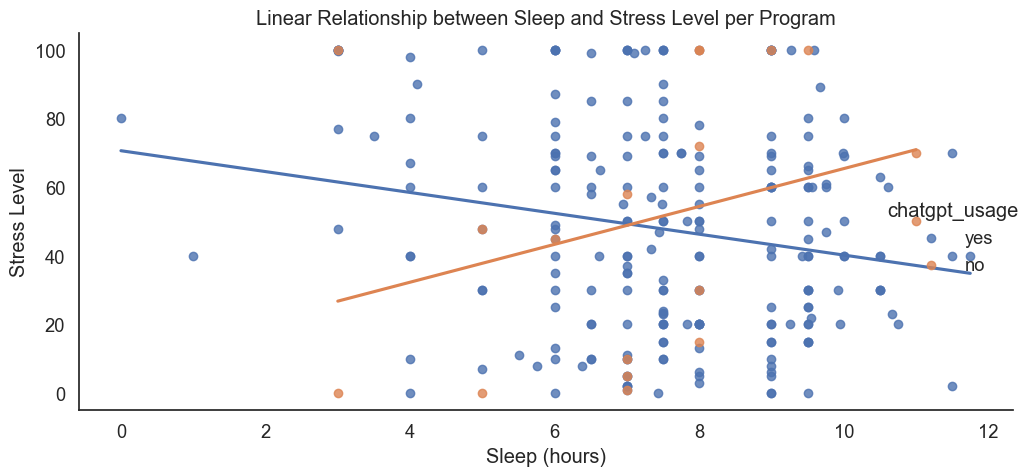

In [235]:

# Plotting linear trends for sleep vs stress_level grouped by program
sns.lmplot(data=basic_data_tidy, x='hours_slept_yesterday', y='stress_level', hue='chatgpt_usage', height=5, aspect=1.8, ci=None)
plt.title('Linear Relationship between Sleep and Stress Level per Program')
plt.xlabel('Sleep (hours)')
plt.ylabel('Stress Level')
plt.tight_layout()
plt.show()

In [94]:
# what is the range of the age?
print(basic_data_tidy['age'].min(), basic_data_tidy['age'].max()) # 22, 43?

# Quantile statistics of the age
print(basic_data_tidy['age'].quantile([0, 0.2, 0.4, 0.6, 0.8, 0.9, 0.95, 1])) # 22, 23, 24

# What about hours slept last night?
print(basic_data_tidy['hours_slept_yesterday'].quantile([0, 0.2, 0.4, 0.6, 0.8, 0.9, 0.95, 1]))

# What is the average stress per program?
average_stress_per_program = basic_data_tidy.groupby('program')['stress_level'].mean()
print(average_stress_per_program)

# What is the average stress per gender?
average_stress_per_gender = basic_data_tidy.groupby('gender')['stress_level'].mean()
print(average_stress_per_gender)


22.0 43.0
0.00   22.00
0.20   23.00
0.40   24.00
0.60   24.00
0.80   25.00
0.90   26.00
0.95   26.80
1.00   43.00
Name: age, dtype: float64
0.00    0.00
0.20    6.00
0.40    7.00
0.60    8.00
0.80    9.50
0.90    9.75
0.95   10.50
1.00   11.75
Name: hours_slept_yesterday, dtype: float64
program
Artificial Intelligence       47.63
Biomedical Science            67.00
Computational Science         49.00
Computer Science              47.27
Econometrics                  41.86
Finance                       43.83
Human Language Technology     15.00
International Public Health   40.00
Security                      59.93
Unknown                       89.40
Name: stress_level, dtype: float64
gender
female   49.63
male     44.15
other    65.60
Name: stress_level, dtype: float64


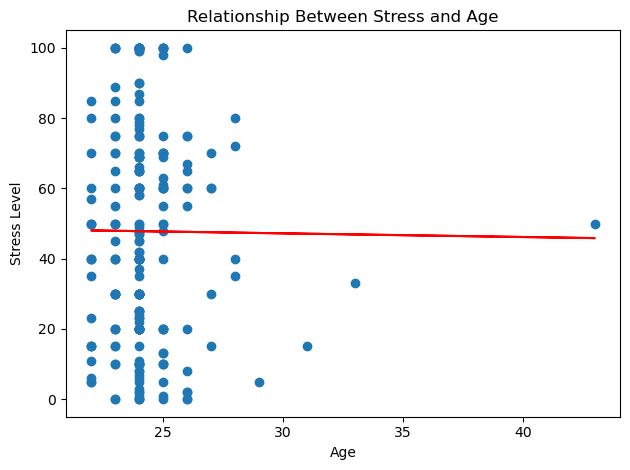

In [95]:
# I'll make a plot of age and stress level
plt.scatter(basic_data_tidy['age'], basic_data_tidy['stress_level'], label='Data Points')

# Calculate a regression line
x = basic_data_tidy['age']
y = basic_data_tidy['stress_level']
m, b = np.polyfit(x, y, 1)

# plot the regression line using that y = mx + b equation
plt.plot(x, m * x + b, color='red')

# add labels and legend
plt.xlabel('Age')
plt.ylabel('Stress Level')
plt.title('Relationship Between Stress and Age')

# this is needed to make the plot look nice when saving it
plt.tight_layout()

# saving this plot for myself
# plt.savefig('Plots/stress-age.png', bbox_inches = 'tight')

# Show the plot
plt.show()

# No correlation! We won't include this in the report then


In [96]:
# Task 2: Classification

# For this, the response variable will be machine_learning. I will use program & the remaining classes as features
class_subset = basic_data_tidy[['machine_learning', 'program', 'program_encoded', 'statistics', 'information_retrieval', 'databases']].copy()

# The first model used will be a neural network, the second will be CatBoost

In [117]:
# Neural network code

# Since I'm using pytorch to speed up the training, I will need to convert the data into a pytorch dataset
class MLClassificationDataset(Dataset):
    def __init__(self, df): # this converts the columns into pytorch tensors
        self.program = torch.tensor(df['program_encoded'].values, dtype=torch.long)
        self.stats = torch.tensor(df['statistics'].values, dtype=torch.float32)
        self.db = torch.tensor(df['databases'].values, dtype=torch.float32)
        self.ir = torch.tensor(df['information_retrieval'].values, dtype=torch.float32)
        self.target = torch.tensor(df['machine_learning'].values, dtype=torch.float32)

    # this tells pytorch how many samples I have
    def __len__(self):
        return len(self.program)

    # this returns a dictionary of features and a target for each sample
    def __getitem__(self, idx):
        return {
            'program': self.program[idx],
            'statistics': self.stats[idx],
            'databases': self.db[idx],
            'information_retrieval': self.ir[idx],
            'target': self.target[idx]
        }

# this code defines the neural network model that I'm using
class MLClassifier(nn.Module):
    def __init__(self, n_programs, embedding_dim = 4):
        super(MLClassifier, self).__init__()
        # this embeds the layer for program_encoded. This is because the variable isn't a dummy variable like the classes were
        self.program_embed = nn.Embedding(num_embeddings=n_programs, embedding_dim=embedding_dim)

        self.fc1 = nn.Linear(embedding_dim + 3, 16)  # 3 dummy variables (the three other classes) + embedding for program_encoded
        self.fc2 = nn.Linear(16, 8)
        self.output = nn.Linear(8, 1) # output returns the probability of the machine learning class
        self.sigmoid = nn.Sigmoid()

    def forward(self, program, stats, db, ir):
        program_embedded = self.program_embed(program) # embeds the program_encoded variable
        x = torch.cat([program_embedded, stats.unsqueeze(1), db.unsqueeze(1), ir.unsqueeze(1)], dim=1) # joins with three dummy variables
        x = torch.relu(self.fc1(x)) # everything gets fed into the dense layers
        x = torch.relu(self.fc2(x)) # everything gets fed into the dense layers
        x = self.sigmoid(self.output(x)) # probility of machine_learning is returned
        return x.squeeze()

# how many programs are there? I need it to set up the model
n_programs = class_subset['program_encoded'].nunique()
model = MLClassifier(n_programs=n_programs, embedding_dim=5)

# some hyperparameters. The Binary classification loss is good working with binary targets
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)

# training/test split. I stratify the machine learning column to keep class balance in the train/test splits
train_df, test_df = train_test_split(class_subset, test_size=0.25, random_state=42, stratify=class_subset['machine_learning']) # stratify=class_subset['machine_learning']

# Both datasets get converted into pytorch datasets
train_dataset = MLClassificationDataset(train_df)
test_dataset = MLClassificationDataset(test_df)

# running the dataloader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True) # prevents learning order
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# This trains the model using the training data, and the average loss for each epoch is reported
n_epochs = 15
for epoch in range(n_epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        outputs = model(batch['program'], batch['statistics'], batch['databases'], batch['information_retrieval'])
        loss = criterion(outputs, batch['target'])
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{n_epochs} - Avg Loss: {avg_loss:.4f}")

# getting ready to test the model accuracy
model.eval()
correct = 0
total = 0

# Collect predictions and true labels
all_preds = []
all_targets = []

# This tests the model using the test data, and the accuracy is reported
with torch.no_grad():
    for batch in test_loader:
        outputs = model(batch['program'], batch['statistics'], batch['databases'], batch['information_retrieval'])
        preds = (outputs >= 0.5).float()
        all_preds.extend(preds.numpy())
        all_targets.extend(batch['target'].numpy())

print(classification_report(all_targets, all_preds, zero_division=0))

print("Predictions:", set(all_preds))
print("Actual targets:", set(all_targets))

#accuracy = correct / total
#print(f"Test Accuracy: {accuracy:.4f}")

# The model never is able to predict a 0 for an observation that has a 0 for machine learning

Epoch 1/15 - Avg Loss: 0.5516
Epoch 2/15 - Avg Loss: 0.5419
Epoch 3/15 - Avg Loss: 0.5286
Epoch 4/15 - Avg Loss: 0.5265
Epoch 5/15 - Avg Loss: 0.5286
Epoch 6/15 - Avg Loss: 0.5204
Epoch 7/15 - Avg Loss: 0.5282
Epoch 8/15 - Avg Loss: 0.5260
Epoch 9/15 - Avg Loss: 0.5215
Epoch 10/15 - Avg Loss: 0.5235
Epoch 11/15 - Avg Loss: 0.5299
Epoch 12/15 - Avg Loss: 0.5239
Epoch 13/15 - Avg Loss: 0.5256
Epoch 14/15 - Avg Loss: 0.5277
Epoch 15/15 - Avg Loss: 0.5229
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        13
         1.0       0.79      1.00      0.88        49

    accuracy                           0.79        62
   macro avg       0.40      0.50      0.44        62
weighted avg       0.62      0.79      0.70        62

Predictions: {np.float32(1.0)}
Actual targets: {np.float32(0.0), np.float32(1.0)}


In [144]:
# CatBoost code

# specify the features and target
features = ['program', 'statistics', 'databases', 'information_retrieval']
target = 'machine_learning'

# train/test split
train_df, test_df = train_test_split(class_subset, test_size=0.2, stratify=class_subset[target], random_state=42)

# Checking out unbalancedness again...
#print(train_df[target].value_counts()) # 154 took machine learning, 42 did not

# specify the categorical variable. Unlike the neural network, I don't need to encode program!
cat_features = ['program']

# Specify the class options for machine learning, so zero and one
classes = np.array([0, 1])

# compute weights. this is being done because as I noticed in the neural network earlier, the column is very unbalanced. There are many more students that took machine learning than those that did not. So while the neural network prioritized accuracy and essentially never correctly predicted a zero, I am trying to avoid that with catboost. Hence I am introducing weights to force catboost to consider zeros and to penalize it if it does not correctly predict a zero
#class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=train_df['machine_learning'])
class_weights = [5, 1] # 10 is too large

# The weights have to be in a specific format in order to be used by catboost
class_weights_dict = {int(k): float(v) for k, v in zip(classes, class_weights)}
print("Class weights:", class_weights_dict) # a very large weight for zero, telling catboost to prioritize the minority class!

# pass it to the model
model = CatBoostClassifier(
    iterations=250,
    learning_rate=0.01,
    depth=8,
    loss_function='Logloss',
    eval_metric='AUC', # Accuracy, AUC, PRC
    cat_features=cat_features,
    class_weights=class_weights_dict,
    verbose=50,
    random_state=42
)

# Fit the model
model.fit(
    train_df[features],
    train_df[target],
    eval_set=(test_df[features], test_df[target]),
    cat_features=cat_features,
    use_best_model=True
)


# Predict labels and probabilities on the test set
preds = model.predict(test_df[features])
probs = model.predict_proba(test_df[features])[:, 1]  # probability of class 1. Remove this if not doing AUC

# Print classification report
print(classification_report(test_df[target], preds, zero_division=0))

# ✅ Print final AUC
auc_score = roc_auc_score(test_df[target], probs)

# Compute precision and recall for different thresholds
precision, recall, _ = precision_recall_curve(test_df[target], probs)

# Compute PR AUC (area under the precision-recall curve)
pr_auc = auc(recall, precision)

print(f"Test PR AUC: {pr_auc:.3f}")     # 0.906
print(f"Test ROC PRC: {auc_score:.3f}") # 0.681

#ROC AUC 0.681 Model is moderately good at separating ML vs. non-ML
#PR AUC 0.906 Model is excellent at finding ML students, despite class imbalance


Class weights: {0: 5.0, 1: 1.0}
0:	test: 0.6051282	best: 0.6051282 (0)	total: 5.03ms	remaining: 1.25s
50:	test: 0.6166667	best: 0.6807692 (2)	total: 44.3ms	remaining: 173ms
100:	test: 0.6192308	best: 0.6807692 (2)	total: 77.6ms	remaining: 114ms
150:	test: 0.6243590	best: 0.6807692 (2)	total: 112ms	remaining: 73.6ms
200:	test: 0.6115385	best: 0.6807692 (2)	total: 155ms	remaining: 37.8ms
249:	test: 0.6089744	best: 0.6807692 (2)	total: 191ms	remaining: 0us

bestTest = 0.6807692308
bestIteration = 2

Shrink model to first 3 iterations.
              precision    recall  f1-score   support

           0       0.30      0.80      0.43        10
           1       0.91      0.51      0.66        39

    accuracy                           0.57        49
   macro avg       0.60      0.66      0.54        49
weighted avg       0.78      0.57      0.61        49

Test PR AUC: 0.906
Test ROC PRC: 0.681


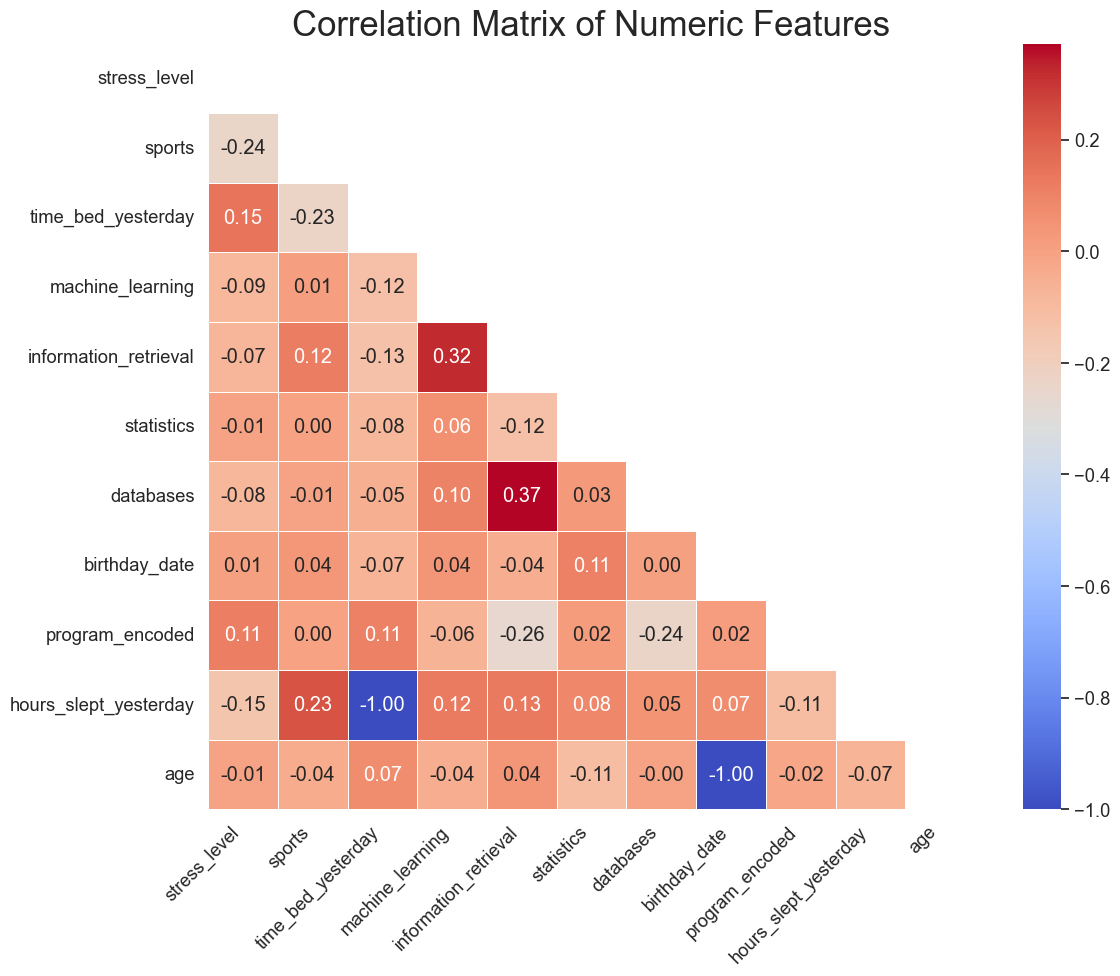

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Compute correlation matrix
cor_mat = basic_data_tidy.select_dtypes(include=['number']).corr()

# 2. Create a mask for the upper triangle
mask = np.triu(np.ones_like(cor_mat, dtype=bool))

# 3. Set a style & context
sns.set_style("white")
sns.set_context("notebook", font_scale=1.2)

# 4. Set up the figure
fig, ax = plt.subplots(figsize=(12, 10))

# 5. Choose a diverging palette centered at zero
cmap = sns.diverging_palette(220, 20, as_cmap=True)

# 3. Draw the heatmap with the original cmap
sns.heatmap(
    cor_mat,
    annot=True,
    mask = mask,
    cmap='coolwarm',
    fmt='.2f',
    linewidths=0.5,

)

# 4. Add a title if you like
plt.title("Correlation Matrix of Numeric Features", size=25)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# 5. Tighten layout
plt.tight_layout()

# 6. Save to file (PNG, 300 dpi)
plt.savefig('correlation_heatmap.png', dpi=300, bbox_inches='tight')

# 7. Display it
plt.show()

In [159]:
cor_mat

,stress_level,sports,time_bed_yesterday,machine_learning,information_retrieval,statistics,databases,birthday_date,program_encoded,hours_slept_yesterday,age
stress_level,1.00,-0.24,0.15,-0.09,-0.07,-0.01,-0.08,0.01,0.11,-0.15,-0.01
sports,-0.24,1.00,-0.23,0.01,0.12,0.00,-0.01,0.04,0.00,0.23,-0.04
time_bed_yesterday,0.15,-0.23,1.00,-0.12,-0.13,-0.08,-0.05,-0.07,0.11,-1.00,0.07
machine_learning,-0.09,0.01,-0.12,1.00,0.32,0.06,0.10,0.04,-0.06,0.12,-0.04
information_retrieval,-0.07,0.12,-0.13,0.32,1.00,-0.12,0.37,-0.04,-0.26,0.13,0.04
statistics,-0.01,0.00,-0.08,0.06,-0.12,1.00,0.03,0.11,0.02,0.08,-0.11
databases,-0.08,-0.01,-0.05,0.10,0.37,0.03,1.00,0.00,-0.24,0.05,-0.00
birthday_date,0.01,0.04,-0.07,0.04,-0.04,0.11,0.00,1.00,0.02,0.07,-1.00
program_encoded,0.11,0.00,0.11,-0.06,-0.26,0.02,-0.24,0.02,1.00,-0.11,-0.02
hours_slept_yesterday,-0.15,0.23,-1.00,0.12,0.13,0.08,0.05,0.07,-0.11,1.00,-0.07


In [148]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from dython.nominal import associations

# 1) Prepare data ---------------------------------------------------------
# Copy your cleaned DataFrame
df = basic_data_tidy.copy()

# 2) Compute association matrix using dython ------------------------------
# This calculates numeric-numeric (Pearson), categorical-categorical (Cramér's V),
# and numeric-categorical (Correlation Ratio) automatically.
assoc_df = associations(
    df,
    nominal_columns=df.select_dtypes(exclude=['number']).columns.tolist(),
    numeric_columns=df.select_dtypes(include=['number']).columns.tolist(),
    theil_u=False,        # set to True to compute Theil's U instead of Cramér's V
    plot=False,           # we'll plot with seaborn
    return_results=True   # return the DataFrame of associations
)

# 3) Plot a clustered heatmap ---------------------------------------------

sns.set_theme(style="whitegrid", font_scale=1.1)

cg = sns.clustermap(
    assoc_df,
    method="average",
    metric="euclidean",
    cmap=sns.diverging_palette(220, 20, as_cmap=True),
    center=0,
    linewidths=0.5,
    annot=True,
    fmt=".2f",
    figsize=(13, 11),
    cbar_kws={"shrink": 0.8, "label": "Association", "ticks": [-1, -0.5, 0, 0.5, 1]}
)

# Tidy up labels and title
cg.ax_heatmap.set_title("Hierarchically Clustered Variable Association", pad=20)
plt.setp(cg.ax_heatmap.get_xticklabels(), rotation=45, ha="right")
plt.setp(cg.ax_heatmap.get_yticklabels(), rotation=0)

# Save high-res for reporting
plt.savefig("association_clustermap.png", dpi=300, bbox_inches="tight")
plt.show()



ContextualVersionConflict: (psutil 5.9.0 (c:\users\nanicomputationalsci\miniconda3\envs\introcomputationalscience\lib\site-packages), Requirement.parse('psutil>=5.9.1'), {'dython'})

In [285]:
# Assume imputed_data is your DataFrame with all features and target column 'stress_level'

# Step 1: Select all candidate features (exclude the target)
all_features = [col for col in basic_data_tidy.columns if col != 'stress_level']

# Step 2: Identify categorical features
# This uses pandas to detect columns with dtype 'object' or 'category'.
categorical_features = list(basic_data_tidy.select_dtypes(include=['object', 'category']).columns)
print("Detected categorical features:", categorical_features)

# Step 3: Remove duplicate features based on correlation (for numerical features only)
# Identify numeric features among the candidates.
numeric_features = [col for col in all_features if col not in categorical_features]

# Compute the absolute correlation matrix for numeric features
corr_matrix = basic_data_tidy[numeric_features].corr().abs()

# Create an upper triangle mask to avoid duplicate checks and ignore self-correlation
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Mark features for removal if any correlation in the upper matrix equals exactly 1
to_drop = [column for column in upper.columns if any(np.isclose(upper[column],1))]

# Selected numeric features after dropping duplicates
selected_numeric = [feature for feature in numeric_features if feature not in to_drop]


# Combine the selected numeric features with all categorical features (retain all categorical ones)
selected_features = selected_numeric + [col for col in all_features if col in categorical_features]

# Determine the categorical features that are present in the final selected features
selected_cat_features = [col for col in categorical_features if col in selected_features]

Detected categorical features: ['program', 'gender', 'good_day1', 'good_day2']


In [244]:
categorical_features

['program', 'gender', 'chatgpt_usage', 'good_day1', 'good_day2']

In [245]:
pd.get_dummies(df, columns=categorical_features, drop_first=True)

,stress_level,sports,time_bed_yesterday,machine_learning,information_retrieval,statistics,databases,birthday_date,program_encoded,hours_slept_yesterday,age,program_Biomedical Science,program_Computational Science,program_Computer Science,program_Econometrics,program_Finance,program_Human Language Technology,program_International Public Health,program_Security,program_Unknown,gender_male,gender_other,chatgpt_usage_yes,good_day1_Food,good_day1_Productive,good_day1_Relaxing,good_day1_Unknown,good_day2_Food,good_day2_Productive,good_day2_Relaxing,good_day2_Unknown
0,78.00,0.00,0.00,1,1,1,1,2001.00,0,8.00,24.00,False,False,False,False,False,False,False,False,False,True,False,True,True,False,False,False,False,False,False,False
1,100.00,2.00,0.50,1,1,0,1,2002.00,0,7.50,23.00,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,True,False,False,False
2,100.00,4.00,0.50,1,1,1,1,2001.00,1,7.50,24.00,False,False,False,True,False,False,False,False,False,True,False,True,False,False,True,False,False,False,False,False
3,60.00,6.00,-1.00,1,0,1,0,2003.00,1,9.00,22.00,False,False,False,True,False,False,False,False,False,True,False,True,False,False,True,False,False,False,True,False
4,50.00,8.00,0.00,1,1,1,1,2000.00,2,8.00,25.00,False,False,True,False,False,False,False,False,False,True,False,True,False,False,False,True,False,False,False,True
5,99.70,8.00,5.00,0,0,1,0,2001.00,1,3.00,24.00,False,False,False,True,False,False,False,False,False,False,True,True,True,False,False,False,True,False,False,False
6,60.00,4.00,0.00,0,0,1,1,1999.00,1,8.00,26.00,False,False,False,True,False,False,False,False,False,False,False,True,False,False,True,False,True,False,False,False
7,30.00,1.00,0.00,1,0,0,1,2001.00,2,8.00,24.00,False,False,True,False,False,False,False,False,False,True,False,True,True,False,False,False,False,False,False,True
8,60.00,3.00,-2.62,0,0,1,1,2001.00,0,10.62,24.00,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,True,False
9,70.00,1.00,2.00,0,0,1,1,2000.00,2,6.00,25.00,False,False,True,False,False,False,False,False,False,False,True,True,False,True,False,False,False,False,False,False


In [168]:
import numpy as np
import pandas as pd
import optuna
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error


# Step 3: Define the objective function for Optuna using the selected features
def objective(trial):
    # Suggest hyperparameters for CatBoostRegressor
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10, log=True),
        'random_strength': trial.suggest_float('random_strength', 1e-3, 10, log=True),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'loss_function': trial.suggest_categorical('loss_function', ['RMSE', 'MAE']),
        'eval_metric': trial.suggest_categorical('eval_metric', ['RMSE', 'MAE']),
        'verbose': 0
    }

    # Use 5-fold Cross Validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    mse_scores = []

    for train_index, val_index in kf.split(basic_data_tidy):
        train_data = basic_data_tidy.iloc[train_index]
        val_data = basic_data_tidy.iloc[val_index]

        train_pool = Pool(
            data=train_data.loc[:, selected_features],
            label=train_data['stress_level'],
            cat_features=selected_cat_features
        )
        val_pool = Pool(
            data=val_data.loc[:, selected_features],
            label=val_data['stress_level'],
            cat_features=selected_cat_features
        )

        # Train the CatBoost model using early stopping; use best model for evaluation if desired
        model = CatBoostRegressor(**params)
        model.fit(train_pool, eval_set=val_pool, early_stopping_rounds=50, use_best_model=True, verbose=0)

        # Evaluate using Mean Squared Error (MSE)
        preds = model.predict(val_pool)
        mse = np.mean((preds - val_data['stress_level']) ** 2)
        mse_scores.append(mse)

    # Return the average MSE across folds (if you prefer RMSE, return np.sqrt(np.mean(mse_scores)) instead)
    return np.mean(mse_scores)

# Run Optuna optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Display the best hyperparameters found
print("Best hyperparameters:", study.best_params)

# Train final model with best hyperparameters using selected features
best_params = study.best_params
final_model = CatBoostRegressor(**best_params)

# Create the Pool for the complete dataset using the selected features
final_pool = Pool(
    data=basic_data_tidy[selected_features],
    cat_features=selected_cat_features,
    label=basic_data_tidy['stress_level']
)

final_model.fit(final_pool, verbose=100)

# Save the final model
final_model.save_model("catboost_stress_model.cbm")


[I 2025-04-19 21:22:28,765] A new study created in memory with name: no-name-4ba29b4d-7f5b-43b4-b4a9-93319308c0c8
[W 2025-04-19 21:22:37,414] Trial 0 failed with parameters: {'iterations': 309, 'depth': 4, 'learning_rate': 0.05840780603196352, 'l2_leaf_reg': 2.8189216399965096, 'random_strength': 8.743561368814204, 'bagging_temperature': 0.09255665500995536, 'border_count': 170, 'loss_function': 'RMSE', 'eval_metric': 'RMSE'} because of the following error: KeyboardInterrupt('').
Traceback (most recent call last):
  File "c:\Users\NaniComputationalSci\miniconda3\envs\IntroComputationalScience\Lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\NaniComputationalSci\AppData\Local\Temp\ipykernel_10228\244240295.py", line 46, in objective
    model.fit(train_pool, eval_set=val_pool, early_stopping_rounds=50, use_best_model=True, verbose=0)
  File "c:\Users\NaniComputationalSci\miniconda3\

KeyboardInterrupt: 

In [240]:
def convert_to_binary(df, column):
    unique_values = df[column].dropna().unique()
    if len(unique_values) == 2:
        mapping = {unique_values[0]: 0, unique_values[1]: 1}
        return df[column].map(mapping)
    else:
        raise ValueError("Column is not binary")

basic_data_tidy['chatgpt_usage'] = convert_to_binary(basic_data_tidy, 'chatgpt_usage')

In [286]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Define features and target
target = 'stress_level'

# Split the data into training and testing sets
X = basic_data_tidy[[selected_numeric, "chatgpt_usage"]]
y = basic_data_tidy[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

# Initialize ElasticNetCV with cross-validation
linearreg = LinearRegression()

# Fit the model
linearreg.fit(X_train, y_train)

# Predict on the test set
y_pred = linearreg.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"R-squared: {r2:.4f}")

# Display the coefficients
print("Elastic Net Coefficients:")
for feature, coef in zip(selected_features, linearreg.coef_):
    print(f"{feature}: {coef:.4f}")

TypeError: unhashable type: 'list'

Training MSE: 924.5939
Test MSE: 1070.3797
Training R-squared: 0.0000
Test R-squared: -0.0726


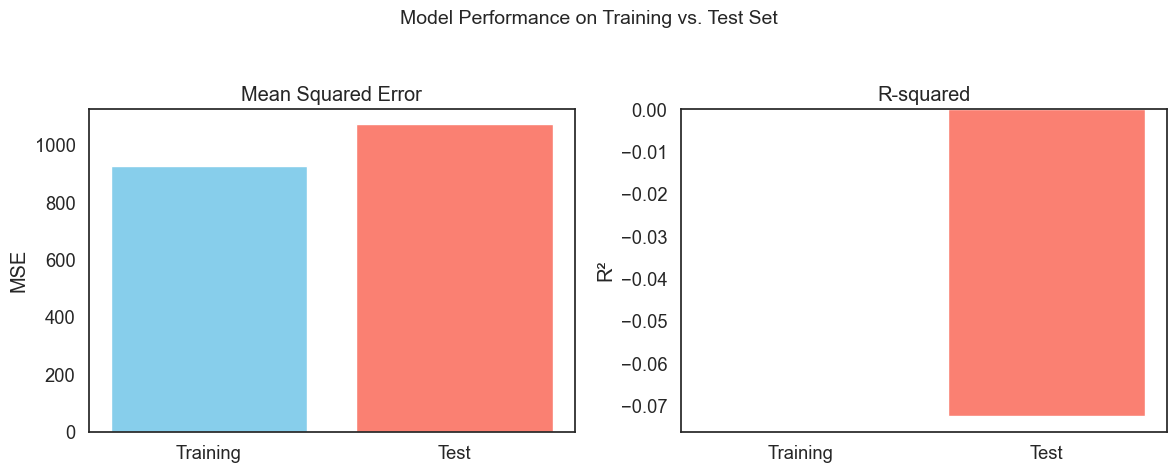


ElasticNet Regression Coefficients:
  sports: -0.0000
  time_bed_yesterday: 0.0000
  machine_learning: -0.0000
  information_retrieval: -0.0000
  statistics: 0.0000
  databases: -0.0000
  chatgpt_usage: 0.0000
  birthday_date: 0.0000
  program_encoded: 0.0000
  hours_slept_yesterday: -0.0000
  age: -0.0000
  program_Biomedical Science: 0.0000
  program_Computational Science: 0.0000
  program_Computer Science: -0.0000
  program_Econometrics: -0.0000
  program_Finance: -0.0000
  program_Human Language Technology: -0.0000
  program_International Public Health: -0.0000
  program_Security: 0.0000
  program_Unknown: 0.0000
  gender_male: -0.0000
  gender_other: 0.0000
  good_day1_Food: 0.0000
  good_day1_Productive: -0.0000
  good_day1_Relaxing: -0.0000
  good_day1_Unknown: 0.0000
  good_day2_Food: 0.0000
  good_day2_Productive: -0.0000
  good_day2_Relaxing: -0.0000
  good_day2_Unknown: -0.0000


In [293]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt


X = basic_data_tidy[numeric_features + categorical_features]
y = basic_data_tidy[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(drop="first"), categorical_features)
    ]
)

pipeline = Pipeline([
    ("preproc", preprocessor),
    ("regressor", ElasticNetCV(l1_ratio=np.linspace(0.01, 0.9, 10), cv=3, random_state=42))
])

# Fit the pipeline
pipeline.fit(X_train, y_train)

# Predict & evaluate
train_pred = pipeline.predict(X_train)
test_pred = pipeline.predict(X_test)

train_mse = mean_squared_error(y_train, train_pred)
test_mse = mean_squared_error(y_test, test_pred)
train_r2 = r2_score(y_train, train_pred)
test_r2 = r2_score(y_test, test_pred)

print(f"Training MSE: {train_mse:.4f}")
print(f"Test MSE: {test_mse:.4f}")
print(f"Training R-squared: {train_r2:.4f}")
print(f"Test R-squared: {test_r2:.4f}")

# Plotting to inspect overfitting
labels = ['Training', 'Test']
mse_values = [train_mse, test_mse]
r2_values = [train_r2, test_r2]

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].bar(labels, mse_values, color=['skyblue', 'salmon'])
ax[0].set_title('Mean Squared Error')
ax[0].set_ylabel('MSE')

ax[1].bar(labels, r2_values, color=['skyblue', 'salmon'])
ax[1].set_title('R-squared')
ax[1].set_ylabel('R²')

plt.suptitle('Model Performance on Training vs. Test Set', fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Inspect coefficients
ohe = pipeline.named_steps["preproc"].named_transformers_["cat"]
ohe_feature_names = ohe.get_feature_names_out(categorical_features)

all_feature_names = numeric_features + list(ohe_feature_names)
coefs = pipeline.named_steps["regressor"].coef_

print("\nElasticNet Regression Coefficients:")
for fname, coef in zip(all_feature_names, coefs):
    print(f"  {fname}: {coef:.4f}")

In [230]:
import numpy as np
from sklearn.linear_model import ElasticNetCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Assume `basic_data_tidy`, `selected_numeric` and `stress_level` are already defined
X = basic_data_tidy[selected_numeric]
y = basic_data_tidy['stress_level']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25
)

# One-liner pipeline with scaling + ElasticNetCV (searching over l1_ratio and alpha)
pipe = make_pipeline(
    LinearRegression()
)


pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

print(f"MSE: {mean_squared_error(y_test, y_pred):.4f}")
print(f"R²:  {r2_score(y_test, y_pred):.4f}")

# Pull out stabilized coefficients
enet = pipe.named_steps['linearregression']
for feat, coef in zip(selected_numeric, enet.coef_):
    print(f"{feat:25s}: {coef:.4f}")


MSE: 887.1091
R²:  0.0706
sports                   : -1.6371
time_bed_yesterday       : 0.8802
machine_learning         : -8.0326
information_retrieval    : 4.2743
statistics               : 2.6289
databases                : 1.1995
birthday_date            : 0.4386
program_encoded          : 0.6725


In [237]:
selected_numeric

['sports',
 'time_bed_yesterday',
 'machine_learning',
 'information_retrieval',
 'statistics',
 'databases',
 'birthday_date',
 'program_encoded']

LinearRegression CV MSE: 26.1655 ± 1.5060


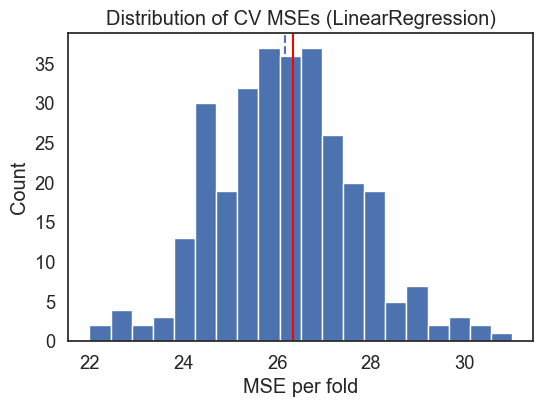

In [304]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RepeatedKFold, cross_validate
from sklearn.metrics import mean_squared_error, make_scorer

# 1) Prepare data and CV strategy
X = basic_data_tidy[selected_numeric]
y = basic_data_tidy['stress_level']
cv = RepeatedKFold(n_splits=3, n_repeats=100, random_state=42)

# 2) Build pipeline: scaling + plain LinearRegression
pipe_lr = make_pipeline(
    StandardScaler(),
    LinearRegression()
)

# 3) Run CV and collect MSEs
mse_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
scores = cross_validate(
    pipe_lr, X, y,
    scoring=mse_scorer,
    cv=cv,
    return_train_score=False
)

mses = -scores['test_score']  # negate because scorer is negative MSE

print(f"LinearRegression CV MSE: {mses.mean():.4f} ± {mses.std():.4f}")

# 4) Plot the distribution of per‐fold MSEs
plt.figure(figsize=(6,4))
plt.hist(mses, bins=20)
plt.axvline(mses.mean(), linestyle='--')
plt.axvline(naive_estimate, linestyle='-', color='red')
plt.xlabel('MSE per fold')
plt.ylabel('Count')
plt.title('Distribution of CV MSEs (LinearRegression)')
plt.show()



In [301]:
naive_estimate = mean_absolute_error(y, np.repeat(y.mean(),len(y)))